In [1]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg
from scipy.interpolate import interp1d, RegularGridInterpolator

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# seed the random number generator
np.random.seed(7)

from spec_exam import Gen_spec
from sim_engine import forward_model_grism, Salmon
import fsps
from spec_id import Scale_model

import dynesty

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(0.019/0.019), sfh = 4, tau = 0.1,
                           dust_type = 1)

Gs = Gen_spec('GND', 21156, 1.2539,
               g102_lims=[7900, 11500], g141_lims=[11100, 16500],
            phot_errterm = 0.03, decontam = True)  

# Gs.Make_sim(0.019, 3.2, 0.2 , 1.2, 0)

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


In [4]:
template_path = '../templates/'
    
tau_range = np.load(template_path + 'tau_range.npy')
metal_range = np.load(template_path + 'metal_range.npy')
age_range = np.load(template_path + 'age_range.npy')
lwagrid = np.load(template_path + 'lwa_grid.npy')

ilwagrid = RegularGridInterpolator([metal_range,tau_range],lwagrid)

In [ ]:
[0.32827658, 3.64719775, 0.5203457 , 1.25376341, 0.20254226]

In [55]:
lwvs = ilwagrid([0.37995,0.058])[0]

interp1d(lwvs,age_range)(4.597)


array(4.71820136)

In [8]:
sp.params['logzsol'] = np.log10( 0.3283 )
sp.params['tau'] = 0.5203
sp.params['dust2'] = 0.202

wave, flux = sp.get_spectrum(tage = 4.9178, peraa = True)

In [4]:
Gs.Scale_flux(0.32827658, 4.91782604, 0.5203457 , 1.25376341, 0.20254226)

In [5]:
Gs.Sim_all(0.3799507 , 4.718, 0.05879592, 1.25560902, 0.02456717)

In [36]:
Bmfl, Rmfl, Pmfl = Full_forward_model(Gs, wave, flux, 1.25376341)

PC= Full_scale(Gs, Pmfl)

Bchi, Rchi, Pchi = Full_fit(Gs, PC * Bmfl, PC * Rmfl, PC * Pmfl)

([<matplotlib.axis.XTick at 0x1a72124860>,
 <a list of 6 Text xticklabel objects>)

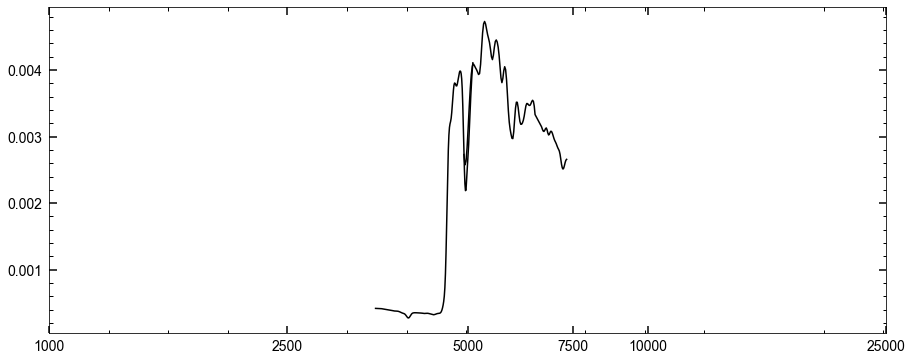

In [8]:
plt.figure(figsize = [15,6])
# plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18,Gs.Ber*1E18,
#                 linestyle='None', marker='o', markersize=3, color='#377eb8')
# plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18,Gs.Rer*1E18,
#                 linestyle='None', marker='o', markersize=3, color='#e41a1c')
# plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
#                                  linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.plot(np.log10(Gs.Bwv_rf), Gs.Bmfl*1E18, 'k')
plt.plot(np.log10(Gs.Rwv_rf), Gs.Rmfl*1E18, 'k')
# plt.plot(np.log10(Gs.Pwv_rf), Gs.Pmfl*1E18, 'ko')



plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])


In [38]:
# prior transform
specz = 1.2539
bft = 0.545
bfd = 0.2

if bft <= 0.5:
    tau_limit = 0.5
    
if 0.5 < bft <= 1.0:
    tau_limit = 1.0
    
if bft > 1.0:
    tau_limit = 2.0
    
if bfd <= 0.5:
    dust_limit = 0.5
    
if 0.5 < bfd <= 1.0:
    dust_limit = 1.0
    
if bfd > 1.0:
    dust_limit = 2.0

def prior_transform(u):
    m = (0.03 * u[0] + 0.001) / 0.019
    a = 5. * u[1] + 0.1
    t = tau_limit*u[2] + 0.01
    z = specz + 0.003 * (2*u[3] - 1)
    d = dust_limit*u[4]
    
    lwvs = ilwagrid([m,t])[0]

    lwa = interp1d(age_range,lwvs)(a)
        
    return [m, lwa, t, z, d]

In [39]:
def forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux):
    FL = np.zeros([len(beams),len(in_wv)])

    for i in range(len(beams)):
        mwv, mflx = forward_model_grism(beams[i], model_wave, model_flux)
        FL[i] = interp1d(mwv, mflx)(in_wv)
        FL[i] /= trans[i]

    return np.mean(FL.T,axis=1)


def Full_forward_model(spec, wave, flux, specz):
    Bmfl = forward_model_all_beams(spec.Bbeam, spec.Btrans, spec.Bwv, wave * (1 + specz), flux)
    Rmfl = forward_model_all_beams(spec.Rbeam, spec.Rtrans, spec.Rwv, wave * (1 + specz), flux)
    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return Bmfl, Rmfl, Pmfl

def Full_scale(spec, Pmfl):
    PC = Scale_model(spec.Pflx, spec.Perr, Pmfl)
    return PC

def Full_fit(spec, Bmfl, Rmfl, Pmfl):
    Bchi = np.sum((((spec.Bfl - Bmfl) / spec.Ber)**2))
    Rchi = np.sum((((spec.Rfl - Rmfl) / spec.Rer)**2))
    Pchi = np.sum((((spec.Pflx - Pmfl) / spec.Perr)**2))
    
    return Bchi, Rchi, Pchi

def loglikelihood(X):
    m,lwa,t,z,d = X
    
    sp.params['logzsol'] = np.log10( m )
    sp.params['tau'] = t
    sp.params['dust2'] = d
    
    lwvs = ilwagrid([m,t])[0]

    a = interp1d(lwvs,age_range)(lwa)
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
        
    Bmfl, Rmfl, Pmfl = Full_forward_model(Gs, wave, flux, z)
    
    PC= Full_scale(Gs, Pmfl)

    Bchi, Rchi, Pchi = Full_fit(Gs, PC * Bmfl, PC * Rmfl, PC * Pmfl)
                  
    return -0.5 * (Bchi + Rchi + Pchi)

In [40]:
import ipyparallel as ipp

rc = ipp.Client()
nprocs = len(rc.ids)
print(rc.ids)

dview = rc[:]
dview.use_dill();

class Pool(object):
    """A simple wrapper for `dview`."""
    
    def __init__(self, dview):
        self.dview = dview
        self.size = nprocs
        
    def map(self, function, tasks):
        return self.dview.map_sync(function, tasks)

# define our pool
pool = Pool(dview)

[0, 1, 2, 3]


In [41]:
%%px

# import environment
import fsps
from spec_exam import Gen_spec
from sim_engine import *
import dynesty
from scipy.interpolate import interp1d, RegularGridInterpolator

specz = 1.2539
bft = 0.545
bfd = 0.2

template_path = '../templates/'
    
tau_range = np.load(template_path + 'tau_range.npy')
metal_range = np.load(template_path + 'metal_range.npy')
age_range = np.load(template_path + 'age_range.npy')
lwagrid = np.load(template_path + 'lwa_grid.npy')

ilwagrid = RegularGridInterpolator([metal_range,tau_range],lwagrid)

if bft <= 0.5:
    tau_limit = 0.5
    
if 0.5 < bft <= 1.0:
    tau_limit = 1.0
    
if bft > 1.0:
    tau_limit = 2.0
    
if bfd <= 0.5:
    dust_limit = 0.5
    
if 0.5 < bfd <= 1.0:
    dust_limit = 1.0
    
if bfd > 1.0:
    dust_limit = 2.0
    
sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau = 0.1,
                           dust_type = 1)

Gs = Gen_spec('GND', 21156, 1.2529, g102_lims=[7900, 11500], g141_lims=[11100, 16500],
            phot_errterm = 0.03, decontam = False)  

def forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux):
    FL = np.zeros([len(beams),len(in_wv)])

    for i in range(len(beams)):
        mwv, mflx = forward_model_grism(beams[i], model_wave, model_flux)
        FL[i] = interp1d(mwv, mflx)(in_wv)
        FL[i] /= trans[i]

    return np.mean(FL.T,axis=1)


def Full_forward_model(spec, wave, flux, specz):
    Bmfl = forward_model_all_beams(spec.Bbeam, spec.Btrans, spec.Bwv, wave * (1 + specz), flux)
    Rmfl = forward_model_all_beams(spec.Rbeam, spec.Rtrans, spec.Rwv, wave * (1 + specz), flux)
    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return Bmfl, Rmfl, Pmfl

def Full_scale(spec, Pmfl):
    PC = Scale_model(spec.Pflx, spec.Perr, Pmfl)
    return PC

def Full_fit(spec, Bmfl, Rmfl, Pmfl):
    Bchi = np.sum((((spec.Bfl - Bmfl) / spec.Ber)**2))
    Rchi = np.sum((((spec.Rfl - Rmfl) / spec.Rer)**2))
    Pchi = np.sum((((spec.Pflx - Pmfl) / spec.Perr)**2))
    
    return Bchi, Rchi, Pchi

# seed the random number generator
np.random.seed(os.getpid())
print('Random seed:',os.getpid())

[stdout:0] Random seed: 53201
[stdout:1] Random seed: 53202
[stdout:2] Random seed: 53207
[stdout:3] Random seed: 53208


[stderr:0] 
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
[stderr:1] 
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data[

In [42]:
# initialize our nested sampler
dsampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim = 5, sample = 'rwalk',pool=pool, bound = 'single') 

# # dsamplerP = dynesty.DynamicNestedSampler(loglikelihood_P, prior_transform, ndim = 5, sample = 'rwalk',pool=pool, bound = 'single') 
# dsamplerB = dynesty.DynamicNestedSampler(loglikelihood_B, prior_transform, ndim = 5, sample = 'rwalk',pool=pool, bound = 'single') 
# dsamplerR = dynesty.DynamicNestedSampler(loglikelihood_R, prior_transform, ndim = 5, sample = 'rwalk',pool=pool, bound = 'single') 

In [43]:
# sample dynamically from the target distribution
dsampler.run_nested(wt_kwargs={'pfrac': 1.0}, dlogz_init=0.001, print_progress=True)

# dsamplerP.run_nested(wt_kwargs={'pfrac': 1.0}, dlogz_init=0.001, print_progress=True)
# dsamplerB.run_nested(wt_kwargs={'pfrac': 1.0}, dlogz_init=0.001, print_progress=True)
# dsamplerR.run_nested(wt_kwargs={'pfrac': 1.0}, dlogz_init=0.001, print_progress=True)


iter: 24264 | batch: 10 | bound: 1088 | nc: 25 | ncall: 573721 | eff(%):  4.229 | loglstar: -127.271 < -120.922 < -121.869 | logz: -131.273 +/-  0.124 | stop:  0.901            


In [44]:
# save results
dres = dsampler.results

# dresP = dsamplerP.results
# dresB = dsamplerB.results
# dresR = dsamplerR.results


In [39]:
'done'

'done'

In [45]:
from dynesty import plotting as dyplot

(<Figure size 1152x1152 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a6f924f98>,
       dtype=object))

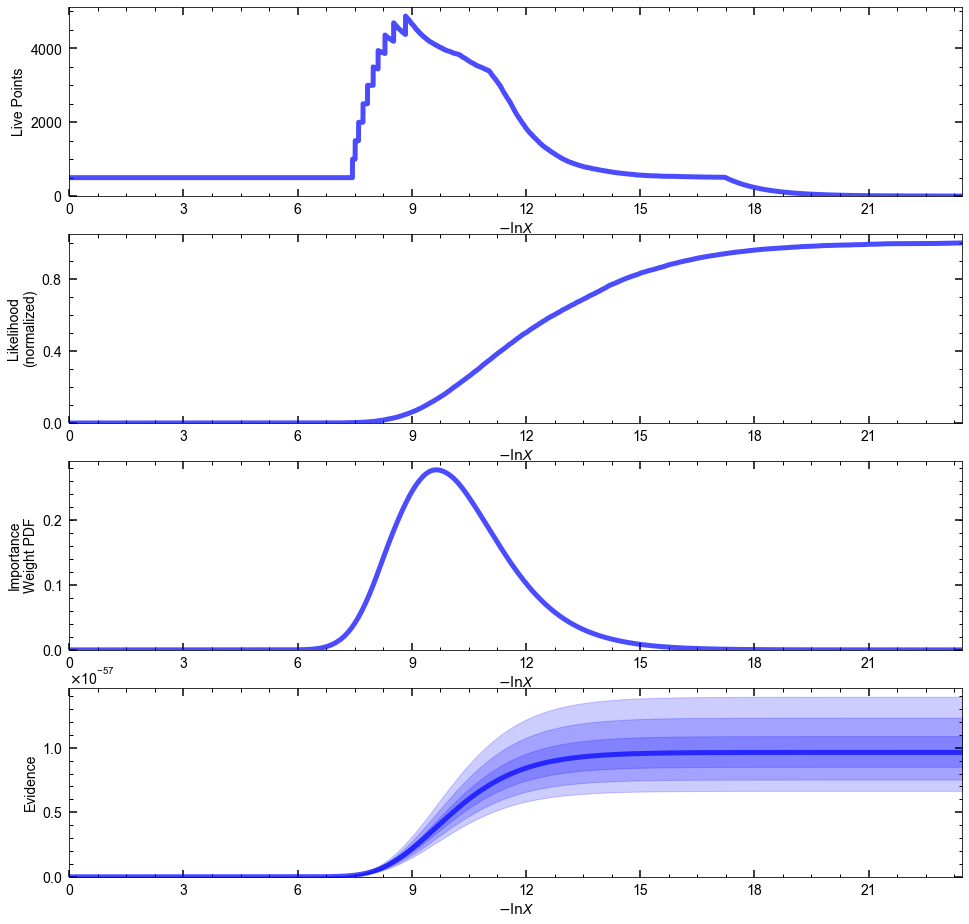

In [47]:
dyplot.runplot(dres)
# dyplot.runplot(dresB)
# dyplot.runplot(dresR)

# fig.tight_layout()

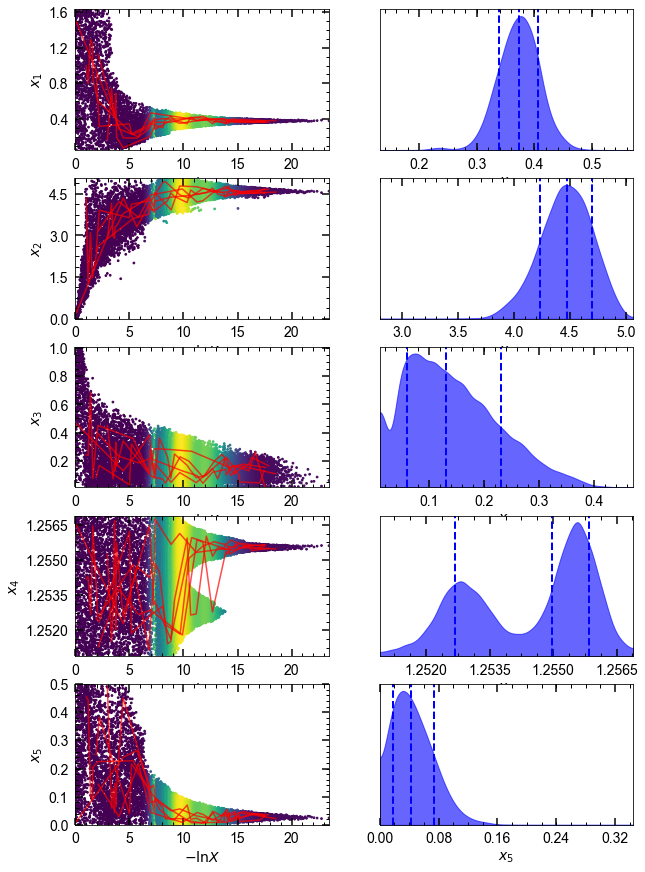

In [48]:
fig, axes = dyplot.traceplot(dres, truths=None, truth_color='black',
                             show_titles=False, title_kwargs={'fontsize': 5, 'y': 1.05},
                             trace_cmap='viridis', kde=False,
                             connect=True, connect_highlight=range(5),
                             fig=plt.subplots(5, 2, figsize=(10, 15)))

(<Figure size 849.6x849.6 with 25 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a6f30b518>,
       dtype=object))

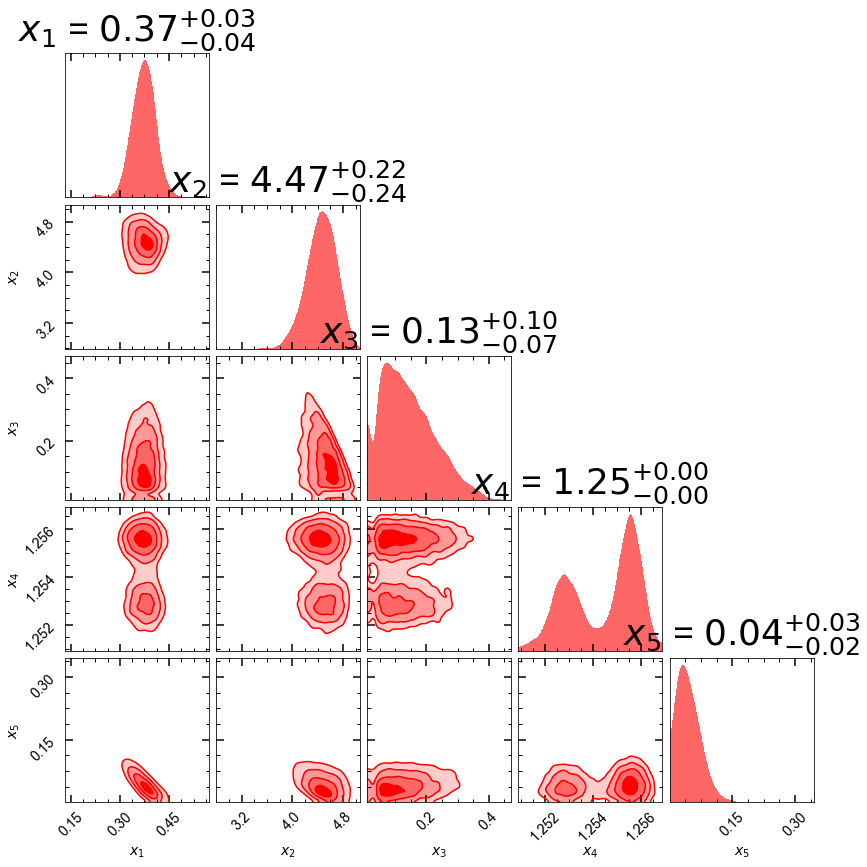

In [49]:
# initialize figure
# fig, axes = plt.subplots(5, 5, figsize=(35, 20))
# axes = axes.reshape((5, 5))

# plot extended run (right)
# fg, ax = 
dyplot.cornerplot(dres, color='red', truths=None, truth_color='black',
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, max_n_ticks=3, )#fig=(fig, axes))

In [43]:
mall = np.append(np.append(dresP.samples[:, 0],dresB.samples[:, 0]),dresR.samples[:, 0])
aall = np.append(np.append(dresP.samples[:, 1],dresB.samples[:, 1]),dresR.samples[:, 1])
wall = np.append(np.append(np.exp(dresP['logwt'] - dresP['logz'][-1]),np.exp(dresB['logwt'] - dresB['logz'][-1])),np.exp(dresR['logwt'] - dresR['logz'][-1]))

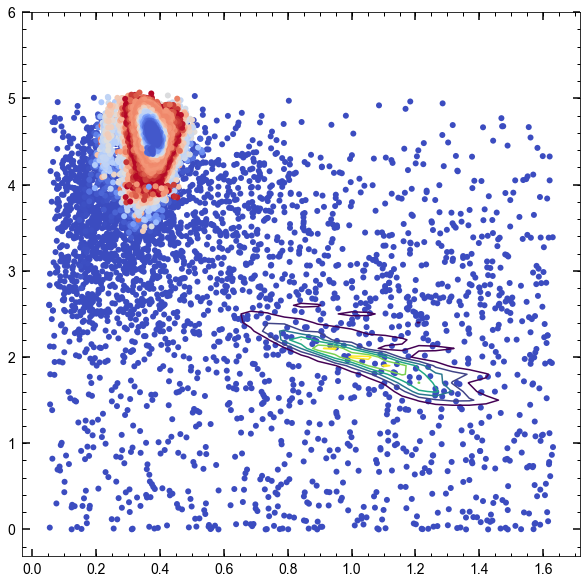

In [50]:
P = np.load('../../Quiescent_analysis/chidat/n21156_dtau_rf_tZ_pos.npy')
metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
M,A=np.meshgrid(metal/0.019,age)

plt.figure(figsize=(10, 10))
plt.scatter(dres.samples[:, 0], dres.samples[:, 1],
               marker='o', c=np.exp(dres['logwt'] - dres['logz'][-1]), linewidths=(0.,), cmap='coolwarm')
plt.contour(M,A,P)


# plt.figure(figsize=(10, 10))
# plt.scatter(dresB.samples[:, 0], dresB.samples[:, 1],
#                marker='o', c=np.exp(dresB['logwt'] - dresB['logz'][-1]), linewidths=(0.,), cmap='coolwarm')
# plt.contour(M,A,P)

# plt.figure(figsize=(10, 10))
# plt.scatter(dresR.samples[:, 0], dresR.samples[:, 1],
#                marker='o', c=np.exp(dresR['logwt'] - dresR['logz'][-1]), linewidths=(0.,), cmap='coolwarm')
# plt.contour(M,A,P)

In [10]:
import seaborn as sea

In [48]:
np.save('../data/out_dict/21156_phot.npy', dresP) 
np.save('../data/out_dict/21156_g102.npy', dresB) 
np.save('../data/out_dict/21156_g141.npy', dresR) 


In [131]:
dres = np.load('../data/out_dict/21156_all.npy').item()
# dresP = np.load('../data/out_dict/21156_phot.npy').item()
# dresG = np.load('../data/out_dict/21156_grism.npy').item()

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


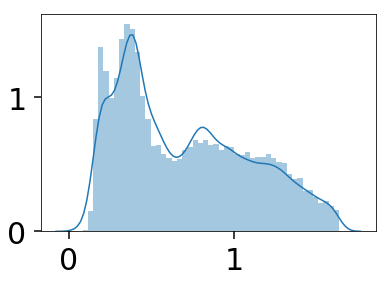

In [46]:
sea.distplot(mall, hist_kws={'weights':wall})

In [90]:
sp.params['dust_type'] = 2

(3.0, 4.698970004336019)

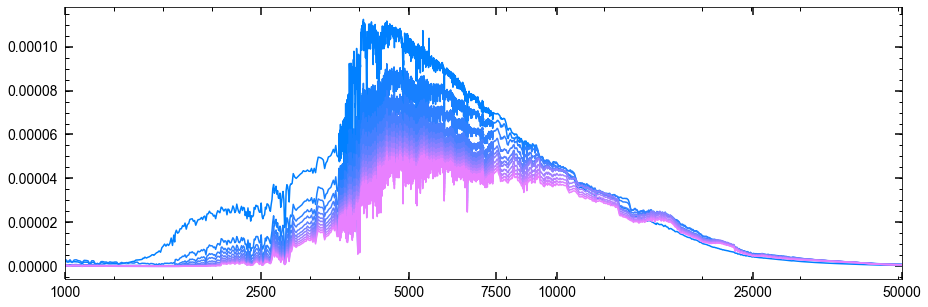

In [95]:

plt.figure(figsize=[15,5])
for i in range(len(metal_range)):
    sp.params['logzsol'] = np.log10(metal_range[i])
    wave,flux = sp.get_spectrum(tage=2.5,peraa=True)
    plt.plot(np.log10(wave),flux , color = [i / len(metal_range),.5,1])

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000,50000]),[1000,2500,5000,7500,10000,25000,50000])
plt.xlim(np.log10(1000),np.log10(50000))


In [71]:
AGE = np.arange(1,6,.1)

(3.0, 4.698970004336019)

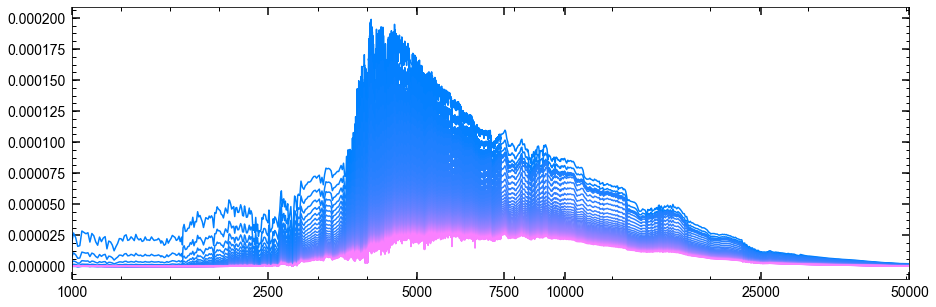

In [93]:
sp.params['logzsol'] = np.log10(1)
sp.params['dust2'] = 0


plt.figure(figsize=[15,5])
for i in range(len(AGE)):
    wave,flux = sp.get_spectrum(tage=AGE[i],peraa=True)
    plt.plot(np.log10(wave),flux, color = [i / len(AGE),.5,1])

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000,50000]),[1000,2500,5000,7500,10000,25000,50000])
plt.xlim(np.log10(1000),np.log10(50000))

In [109]:
DUST = np.arange(0,1.5,.1)

(3.0, 4.698970004336019)

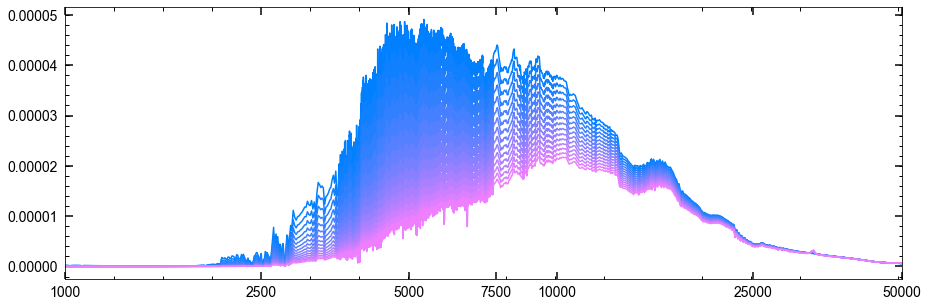

In [118]:
sp.params['logzsol'] = np.log10(0.019/0.019)
sp.params['mwr'] = 3.1
sp.params['uvb'] = 1


plt.figure(figsize=[15,5])
for i in range(len(DUST)):
    sp.params['dust2'] = DUST[i] 
    
    wave,flux = sp.get_spectrum(tage=3.0,peraa=True)
    plt.plot(np.log10(wave),flux , color = [i / len(DUST),.5,1])

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000,50000]),[1000,2500,5000,7500,10000,25000,50000])
plt.xlim(np.log10(1000),np.log10(50000))

/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:264: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:266: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:273: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:275: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)


(3.0, 4.698970004336019)

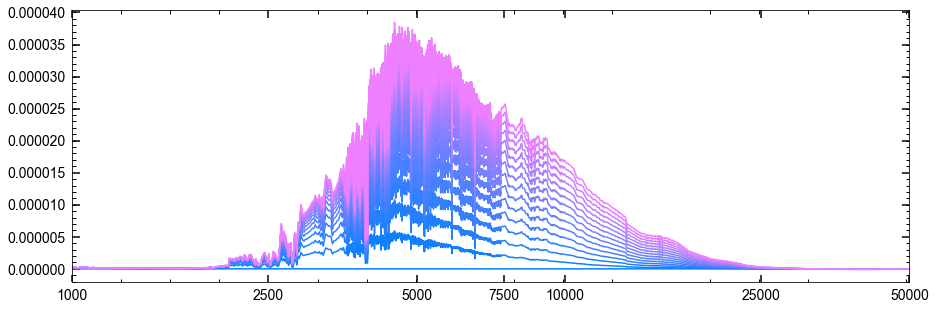

In [120]:
sp.params['logzsol'] = np.log10(0.019/0.019)
sp.params['mwr'] = 3.1
sp.params['uvb'] = 1
sp.params['dust2'] = 0

plt.figure(figsize=[15,5])
for i in range(len(DUST)): 
    sp.params['dust2'] = DUST[i] 
    
    wave1,flux1 = sp.get_spectrum(tage=3.0,peraa=True)
    
    sp.params['dust2'] = 0

    wave2,flu2 = sp.get_spectrum(tage=3.0,peraa=True)
    plt.plot(np.log10(wave),flux - flux * Salmon(DUST[i],wave) , color = [i / len(DUST),.5,1])

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000,50000]),[1000,2500,5000,7500,10000,25000,50000])
plt.xlim(np.log10(1000),np.log10(50000))

(3.0, 4.698970004336019)

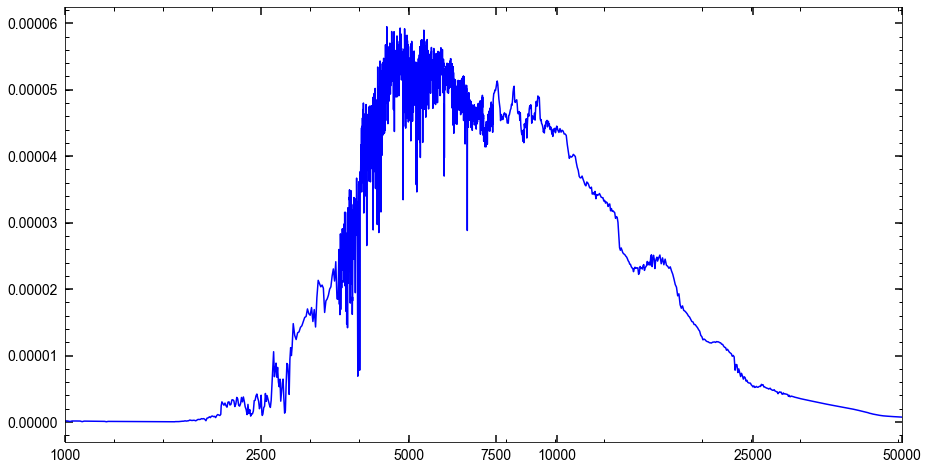

In [61]:
plt.figure(figsize=[15,8])
sp.params['logzsol'] =np.log10(1)
wave,flux = sp.get_spectrum(tage=2.5,peraa=True)
plt.plot(np.log10(wave),flux,color=[0,0,1])
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000,50000]),[1000,2500,5000,7500,10000,25000,50000])
plt.xlim(np.log10(1000),np.log10(50000))
# plt.ylim(-0.000001,0.00001)

In [51]:
len(dres.logl), np.where(dres.logl == np.max(dres.logl))

(24264, (array([24263]),))

In [52]:
dres.samples[24263]

array([0.3799507 , 4.59748208, 0.05879592, 1.25560902, 0.02456717])